In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['font.family'] = 'Lato'
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
import rotations as gym_rotations
import os

In [2]:
best_worst = '/Users/martinhwasser/Dropbox/Public/kth/det2stoc_icra/data/last_data/scale3/ppo2_cheezit.xml_task_1_1500_friction0.1_com0.0.pkl/'
left_foam = 'real_yumi_500g_left_foam_ep16.npy'
right_nofoam = 'real_yumi_500g_right_nofoam_ep12.npy'


finetuned = '/Users/martinhwasser/Dropbox/Public/kth/det2stoc_icra/data/last_data/scale3/ppo2_finetune_cheezit.xml_task_1_1000_fri(0.79487956, 0.25118738)_com(0.0708277, 0.012763385)_alpha_ratio0.5.pkl/'
left_finetuned_foam = 'real_yumi_500g_left_foam_ep16.npy'

runs = [os.path.join(best_worst, right_nofoam),
        os.path.join(best_worst, left_foam),
        os.path.join(finetuned, left_finetuned_foam)]

labels = ['bestworst_wtdown_nopad',
          'bestworst_wtup_onpad',
          'finetuned_wtup_onpad']

In [3]:
DOF = 14
ROT = 9
GOAL_POS_START_ID = 2*DOF
GOAL_ROT_START_ID = GOAL_POS_START_ID+3
TGT_POS_START_ID = 2*DOF + 3*(3+ROT)
TGT_ROT_START_ID = TGT_POS_START_ID+3

In [4]:
# Note: only need to swap quat w when get data from ROS.
def mat2euler(mat, debug=False):
        #result = np.empty(4, type=np.double)
        #functions.mju_mat2Quat(result, np.asarray(mat))
        quat = gym_rotations.mat2quat(mat.reshape(3,3))
        euler = gym_rotations.quat2euler(quat)
        if debug: print('quat', quat, 'euler', euler)
        return euler

# From Martin's code
def get_distance(a, b):
    return np.linalg.norm(a - b, axis=-1)

# From Martin's code
def get_goal_distance(achieved_goal, desired_goal):
    pos1, pos2 = achieved_goal[:3], desired_goal[:3]
    pos_distance = get_distance(pos1, pos2)
    return pos_distance

# From Martin's code
def get_pos_reward(distance, close=0.01, margin=0.2):
    return max(0, 1-distance/margin)

# From Martin's code
def compute_reward(achieved_goal, desired_goal, debug=False):
    pos_distance = get_goal_distance(achieved_goal, desired_goal)
    euler1, euler2 = achieved_goal[3:], desired_goal[3:]
    ang_distance = np.linalg.norm(gym_rotations.subtract_euler(euler1, euler2), axis=-1)
    pos_reward = get_pos_reward(pos_distance)
    ang_distance_ratio = 1.0
    ang_distance_penalty = ang_distance_ratio*ang_distance
    reward = pos_reward - ang_distance_penalty
    if debug:
        print('Reward: %f, pos reward: %f, ang_distance: %f' % \
              (reward, pos_reward, ang_distance_penalty))
        print('euler1', euler1)
        print('euler2', euler2)
    return reward


# Format for observations (states): 14+14+3+9+ 3+9+3+9+ 3+9+ 3+9 +3 = 91
# obs = np.concatenate([pos, vel, self.goal_pos, goal_rot_mat,
#   gripper_l_trans, gripper_l_rot_mat, gripper_r_trans, gripper_r_rot_mat,
#     self.target_history[-1], target_velocity, self.target_info])
# self.target_info = [0.03, 0.079, 0.105]
def extract_reward(obs):
    goal_pos = obs[GOAL_POS_START_ID:GOAL_POS_START_ID+3]
    goal_rot = obs[GOAL_ROT_START_ID:GOAL_ROT_START_ID+9]
    tgt_pos = obs[TGT_POS_START_ID:TGT_POS_START_ID+3]
    tgt_rot = obs[TGT_ROT_START_ID:TGT_ROT_START_ID+9]
    goal_euler = mat2euler(goal_rot, debug=False)
    goal_all = np.hstack([goal_pos, goal_euler])
    tgt_euler = mat2euler(tgt_rot)
    box_all = np.hstack([tgt_pos, tgt_euler])
    rwd = compute_reward(box_all, goal_all, debug=False)
    return rwd

<Figure size 1080x1800 with 0 Axes>

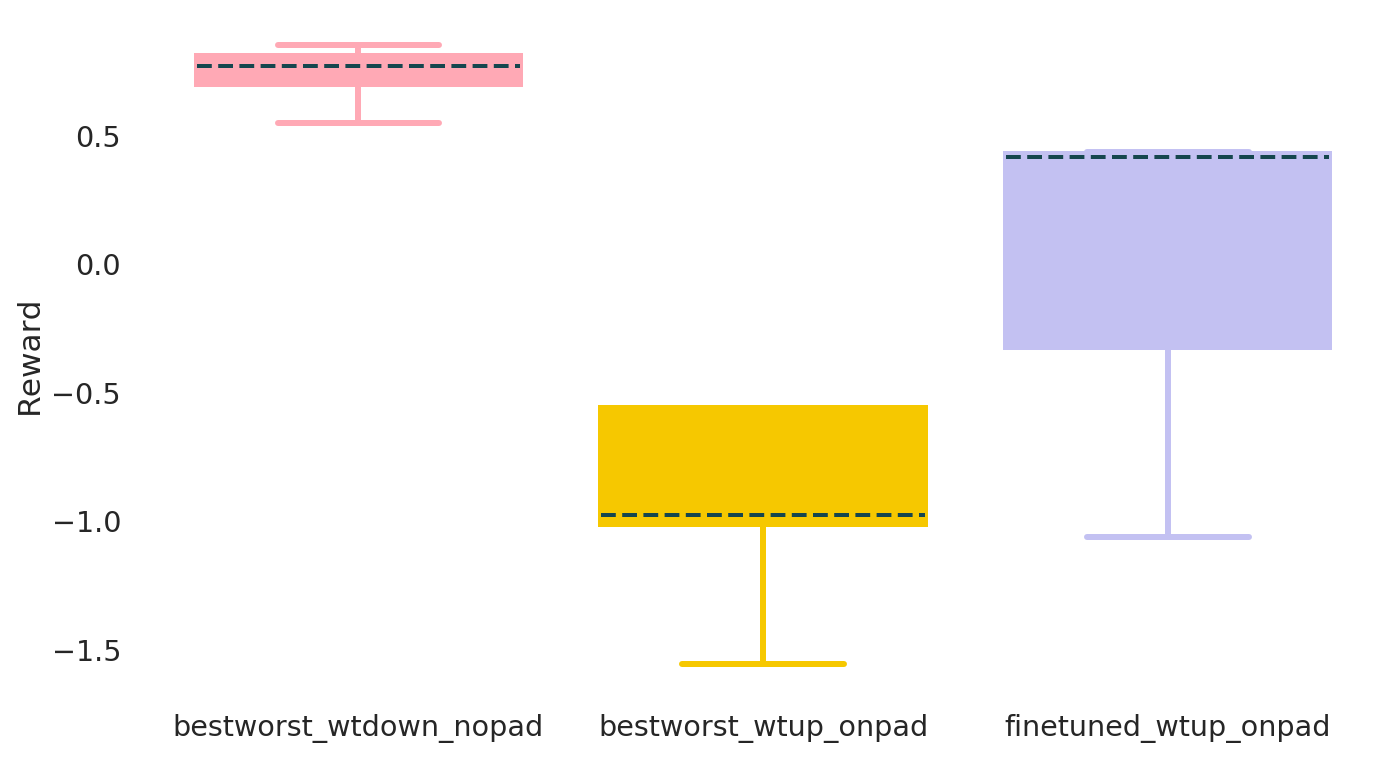

In [5]:
fig = plt.figure(figsize=(15,25))

palette = sns.color_palette('Set2', 10)
colors = ['#ffa9b5', '#f6c800', '#757b33', '#15464e', '#cfebef', '#c3c1f2']
colors = ['#ffa9b5', '#f6c800', '#c3c1f2', '#757b33', '#15464e', '#cfebef']
palette = sns.color_palette(colors)
vert = True
idx = 0

sns.set(font_scale=1.3)
sns.set_style('dark', {'axes.facecolor': '#ffffff',#'#fbfbfb',
                       'font.family': ['DejaVu Sans']})
                       
widths = [0.2] * 3
positions = np.array([-0.25, 0, 0.25])

final_rewards = []
for path in runs:
    #ax = plt.subplot(6,3,row+1)
    with open(path, 'rb') as f:
        data = np.load(f, allow_pickle=True).item()
        final_states = data['final_states']

    final_reward = [extract_reward(final_states[i]) for i in range(len(final_states))]
    final_rewards.append(final_reward)
    
fig, ax = plt.subplots(figsize=(10,6))
for i in range(len(runs)):
    ax.boxplot(final_rewards[i],
               vert=vert,
               widths=0.2,
               manage_ticks=False,
               patch_artist=True, 
               showfliers=False, # This would show outliers (the remaining .7% of the data)
               positions = positions[i:i+1],
               boxprops = dict(linestyle='--', linewidth=3, color=palette[i], facecolor=palette[i], alpha=1),
               medianprops = dict(linestyle='--', linewidth=2, color=palette[-2], label='median'),
               whiskerprops = dict(linestyle='-', linewidth=3, color=palette[i], alpha = 1),
               capprops = dict(linestyle='-', linewidth=3, color=palette[i], alpha=1),
               flierprops = dict(marker='o', markerfacecolor=palette[i], markeredgecolor='none', markersize=5,
                  linestyle='none', alpha=1),
               #labels=runs[i],
              )
    #ax.set_title('Log likelihood: {:.3f}, KL: {:.3f}'.format(ll_per_dim[row], kl_per_dim[row]))
    ax.set_xticklabels(labels)
    #ax.set_yticks(ax.get_yticks()[::5])
    ax.set_xticks(positions)
    ax.set_ylabel('Reward')
    #ax.legend('--')

    #plt.suptitle('Step: {}, total log likelihood over all dims: {:.3f}'.format(step, np.mean(logprob)), fontsize=20)
plt.tight_layout(w_pad=2, h_pad=2, rect=[0, 0.03, 1, 0.95])
plt.show()